# Imports

In [1]:
import json
import math
import os

import copy
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm

import kornia.augmentation as K
import kornia.color as C

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision.transforms import ToTensor
from torchvision.transforms import v2
from torchvision.transforms.functional import pil_to_tensor
from torchvision.datasets import INaturalist
from torchvision import models

# from torchinfo import summary

# Checking device

In [2]:
print("CUDA available?", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0))
print("Current device:", torch.cuda.current_device())

# device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("cpu")

print("Using:", device)

CUDA available? True
Device name: NVIDIA GeForce RTX 4090
Current device: 0
Using: cuda:0


# Experiment setup

In [3]:
setup = {
    "experiment": "efficientnet_b4-10000-SGD-CELoss",
    "num_classes": 10000,
    "batch_size": 32,
    "num_workers": 8,
    "prefetch_factor": 2,
    "criterion": nn.CrossEntropyLoss(),
    "lr": 1e-4,
    "weight_decay": 1e-4,
    "momentum": 0.9,
    "max_epochs": 30
}

folder = f"./experiments/{setup['experiment']}"
os.makedirs(folder, exist_ok=True)
file_path = os.path.join(folder, 'setup.txt')

with open(file_path, 'w', encoding='utf-8') as f:
    json.dump(setup, f, indent=4, ensure_ascii=False, default=str)

print(f"Saved in: {file_path}")

tensorboard_path = f'./experiments/{setup["experiment"]}/tensorboard/'
models_path = f"./experiments/{setup['experiment']}/models/"

os.makedirs(os.path.join(tensorboard_path), exist_ok=True)
os.makedirs(os.path.join(models_path), exist_ok=True)

Saved in: ./experiments/efficientnet_b4-10000-SGD-CELoss/setup.txt


# Tensorboard functions

In [4]:
def plot_net_attributes(epoch, net, writer):
    layers = list(net.modules())

    layer_id = 1
    for layer in layers:
        if isinstance(layer, nn.Linear) :
            writer.add_histogram(f'Bias/linear-{layer_id}', layer.bias, epoch )
            writer.add_histogram(f'Weight/linear-{layer_id}', layer.weight, epoch )
            writer.add_histogram(f'Grad/linear-{layer_id}', layer.weight.grad, epoch )
            layer_id += 1

# Augmentations

In [5]:
mean = [0.4650194027653909, 0.48128506681789435, 0.37711871442015105]
std = [0.24237112423460933, 0.23366727265227194, 0.25144634756835477]

class ToTensorModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.to_tensor = ToTensor()
    def forward(self, x):
        return self.to_tensor(x)

train_transform = torch.nn.Sequential(
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    
    K.RandomResizedCrop((224,224)),
    
    K.RandomHorizontalFlip(p=0.5),

    K.Normalize(mean=mean, std=std, p=1.0)
)

test_transform = torch.nn.Sequential(
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    
    K.CenterCrop((224,224)),
    
    K.Normalize(mean=mean, std=std, p=1.0)
)

## View

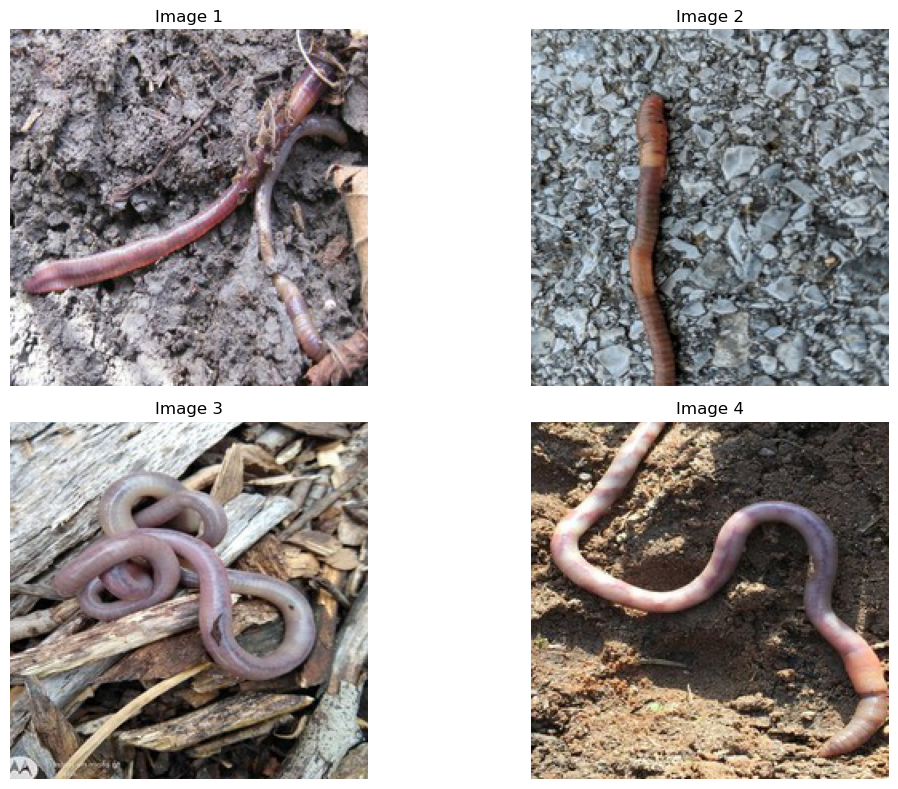

In [6]:
train_transform_view = torch.nn.Sequential(
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    
    K.RandomCrop((224,224)),
)

img_dir  = "../dataset/species/2021_train_mini/00000_Animalia_Annelida_Clitellata_Haplotaxida_Lumbricidae_Lumbricus_terrestris"

img_files = [f for f in os.listdir(img_dir) if f.endswith(".jpg")]

N = 4
img_files = img_files[:N]

cols = 2
rows = N // cols + int(N % cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))

for idx, img_fname in enumerate(img_files):
    pil = Image.open(os.path.join(img_dir, img_fname)).convert("RGB")

    out = train_transform_view(pil)
    out = out.squeeze(0).permute(1,2,0).cpu().numpy()

    r, c = divmod(idx, cols)
    ax = axes[r, c]
    ax.imshow(out)
    ax.set_title(f"Image {idx+1}")
    ax.axis("off")
    
plt.tight_layout()
plt.show()

# INaturalist

## Dataset

In [7]:
# train_dataset = INaturalist(
#     root='../dataset/species/',
#     version='2021_train_mini',
#     transform=train_transform,
#     download=False
# )

# test_dataset = INaturalist(
#     root='../dataset/species/',
#     version='2021_valid',
#     transform=test_transform,
#     download=False
# )

# print(train_dataset)
# print("\nTrain sample:")
# train_sample = train_dataset[0]
# print(train_sample[0].shape)
# print()

# print(test_dataset)
# print("\nTest sample:")
# test_sample = test_dataset[0]
# print(test_sample[0].shape)
# print()

# train_dataloader = DataLoader(
#     train_dataset,
#     batch_size=setup["batch_size"],
#     shuffle=True,
#     num_workers=setup["num_workers"],
#     pin_memory=True,
#     persistent_workers=True,
#     prefetch_factor=setup["prefetch_factor"]
# )

# test_dataloader = DataLoader(
#     test_dataset,
#     batch_size=setup["batch_size"],
#     shuffle=False,
#     num_workers=setup["num_workers"],
#     pin_memory=True,
#     persistent_workers=True,
#     prefetch_factor=setup["prefetch_factor"]
# )

Dataset INaturalist
    Number of datapoints: 500000
    Root location: ../dataset/species/2021_train_mini
    StandardTransform
Transform: Sequential(
             (0): ToImage()
             (1): ToDtype(scale=True)
             (2): RandomResizedCrop(scale=(0.08, 1.0), resize_to=(0.75, 1.3333333333333333), output_size=(224, 224), p=1.0, p_batch=1.0, same_on_batch=False, size=(224, 224), resample=bilinear, align_corners=True, cropping_mode=slice, padding_mode=zeros)
             (3): RandomHorizontalFlip(p=0.5, p_batch=1.0, same_on_batch=False)
             (4): Normalize(p=1.0, p_batch=1.0, same_on_batch=True, mean=tensor([0.4650, 0.4813, 0.3771]), std=tensor([0.2424, 0.2337, 0.2514]))
           )

Train sample:
torch.Size([1, 3, 224, 224])

Dataset INaturalist
    Number of datapoints: 100000
    Root location: ../dataset/species/2021_valid
    StandardTransform
Transform: Sequential(
             (0): ToImage()
             (1): ToDtype(scale=True)
             (2): CenterCrop(p=

# NaBird

## Dataset

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn

class NABirdsDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        root_dir deve conter:
          - images/               (todas as imagens, organizadas em subpastas ou não)
          - images.txt            (ID e caminho relativo de cada imagem)
          - image_class_labels.txt (ID e label numérico de cada imagem)
          - train_test_split.txt  (ID e flag 1=train / 0=val)
        """
        self.root_dir = root_dir
        self.transform = transform

        # 1) mapeia ID → caminho de arquivo
        id2path = {}
        with open(os.path.join(root_dir, "images.txt")) as f:
            for line in f:
                img_id, rel_path = line.strip().split()
                id2path[int(img_id)] = rel_path

        # 2) mapeia ID → classe (0-based)
        id2label = {}
        with open(os.path.join(root_dir, "image_class_labels.txt")) as f:
            for line in f:
                img_id, lbl = line.strip().split()
                id2label[int(img_id)] = int(lbl) - 1  # labels começam em 1

        # 3) define quais IDs são de treino e quais são de validação
        target_flag = '1' if split == 'train' else '0'
        self.samples = []
        with open(os.path.join(root_dir, "train_test_split.txt")) as f:
            for line in f:
                img_id, flag = line.strip().split()
                if flag == target_flag:
                    img_id = int(img_id)
                    self.samples.append((id2path[img_id], id2label[img_id]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        rel_path, label = self.samples[idx]
        img_path = os.path.join(self.root_dir, "images", rel_path)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

data_root = "/caminho/para/NABirds"  # ajuste para o seu local

train_dataset = NABirdsDataset(data_root, split='train', transform=train_transforms)
test_dataset   = NABirdsDataset(data_root, split='test',   transform=val_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True)
test_dataloader   = DataLoader(test_dataset,   batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)

# Architecture

In [8]:
weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1

net = models.efficientnet_b0(weights=weights)

for param in net.parameters():
    param.requires_grad = False

num_features = net.classifier[1].in_features
net.classifier[1] = nn.Linear(num_features, setup['num_classes'])

## View

In [9]:
print(net.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=10000, bias=True)
)


In [10]:
for name, param in net.named_parameters():
    if param.requires_grad == True:
        print(name, param.requires_grad)

classifier.1.weight True
classifier.1.bias True


In [11]:
# summary(net, input_size=(setup['batch_size'], 3, 224, 224))

# Train

In [12]:
def train(net, train_dataloader, test_dataloader, device):
  
    net.to(device)

    optimizer = torch.optim.SGD(
        filter(lambda p: p.requires_grad, net.parameters()),
        lr=setup['lr'],
        weight_decay=setup['weight_decay'],
        momentum=setup['momentum'])

    criterion = setup['criterion']
    criterion.to(device)

    writer = SummaryWriter(log_dir=tensorboard_path)
    writer.add_graph(net, next(iter(train_dataloader))[0].to(device))

    max_accuracy = -1.0

    for epoch in tqdm(range(setup['max_epochs'])):
        
        net.train()  

        train_loss, train_accuracy = [], []

        for train_batch in train_dataloader:
            
            train_x, train_label = train_batch
            train_x = train_x.to(device)
            train_label = train_label.to(device)

            optimizer.zero_grad()

            outs = net(train_x)
    
            loss = criterion(outs, train_label)

            train_loss.append(loss.item())
            
            loss.backward()
            optimizer.step()

            predict_labels = torch.max(outs, axis=1)[1]
            correct = torch.sum(predict_labels == train_label).item()
            accuracy = correct/train_label.size(0)

            train_accuracy.append(accuracy)

            plot_net_attributes(epoch, net, writer)

        train_loss = np.asarray(train_loss)
        train_accuracy = np.asarray(train_accuracy)

        val_loss, val_accuracy = validate(net, criterion, test_dataloader, device)

        writer.add_scalar('Loss/train', train_loss.mean(), epoch)
        writer.add_scalar('Loss/val', val_loss.mean(), epoch)
        writer.add_scalar('Accuracy/train', train_accuracy.mean(), epoch)
        writer.add_scalar('Accuracy/val', val_accuracy.mean(), epoch)
            
        if val_accuracy.mean() > max_accuracy:
            best_model = copy.deepcopy(net)
            max_accuracy = val_accuracy.mean()
            print(f'Saving the model with the best accuracy: {max_accuracy:3.4f}')
            
        print(f'Epoch: {epoch+1:3d} | Loss/train: {train_loss.mean():3.4f}% | Accuracy/train: {train_accuracy.mean():3.4f}% |\
            Loss/val: {val_loss.mean():3.4f}% | Accuracy/val: {val_accuracy.mean():3.4f}% |')

    path = f'{models_path}{setup["experiment"]}-{max_accuracy:.2f}.pkl'
    torch.save(best_model, path)
    print(f'Best model saved in: {path}')

    writer.flush()
    writer.close()
    
    return best_model

# Validate

In [13]:
def validate(net, criterion, test_dataloader, device):

    net.eval()
    net.to(device)

    val_loss, val_accuracy = [], []

    for test_batch in test_dataloader:

        test_x, test_label = test_batch
        test_x = test_x.to(device)
        test_label = test_label.to(device)

        with torch.no_grad():
            outs = net(test_x).detach()

            loss = criterion(outs, test_label)
            
            val_loss.append(loss.item())
    
            predict_labels = torch.max(outs, axis=1)[1]
            correct = torch.sum(predict_labels == test_label).item()
            accuracy = correct/test_label.size(0)
    
            val_accuracy.append(accuracy)
        
    val_loss = np.asarray(val_loss)
    val_accuracy = np.asarray(val_accuracy)

    return val_loss, val_accuracy

# Fit

In [14]:
best_model = train(net, train_dataloader, test_dataloader, device)

Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [32, 1, 3, 224, 224]
Error occurs, No graph saved


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [32, 1, 3, 224, 224]